# Training UNet for drop segmentation

In [317]:
import torch
from checkpoints import *
from measures import *

In [318]:
config = {
    "lr": 0.004,
    "batch_size": 8,
    "epochs": 150,
    "threshold": 0.3,
    "init_from_checkpoint": False,
    "input_mode": "RGB",
    "milestones": [8, 16, 48, 60, 70, 100],
    "gamma":  0.63,
    "image_dir": '../../data/stereo/train/image',
    "mask_dir": '../../data/stereo/train/mask',
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "checkpoint_dir": "checkpoints",
    "checkpoint": None, # if None loads last saved checkpoint
    "print_model": False,
    "use_wandb": False,
    "binarization": True,
    "seed": 3360247224510423906 # if None uses random seed,
}

config["channels"] = len(config["input_mode"]) - int('I' in config["input_mode"])
print(f"Training using {config['device']}")

Training using cuda


In [319]:
# Set seed
if config["seed"] is not None:
    seed = config["seed"]
else:
    seed = torch.random.seed()
torch.manual_seed(seed)    
print('Seed', seed)

Seed 3360247224510423906


In [320]:
def random_split(dataset, val_percent=0.15, test_percent=0.15):
    val_size = int(len(dataset) * val_percent)
    test_size = int(len(dataset) * test_percent)
    train_size = len(dataset) - val_size - test_size
    return torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [321]:
# Load train and val datasets and prepare loaders

from torch.utils.data import DataLoader
import importlib
import dataset
importlib.reload(dataset)
from dataset import WaterDropDataset
dataset = WaterDropDataset(
    mode=config["input_mode"],
    image_dir=config["image_dir"],
    mask_dir=config["mask_dir"],
    binarization = config["binarization"],
    threshold=config["threshold"],
    crop_shape=(256, 256)
)

assert dataset, "Dataset is empty!"

train_dataset, val_dataset, test_dataset = random_split(dataset, 0.1, 0.1)
train_loader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config["batch_size"],
    shuffle=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=config["batch_size"],
    shuffle=True
)

print (f'Loaded {len(dataset)} images\n')
print (f'Train: {len(train_dataset)} images, {len(train_loader)} batches')
print (f'Val:   {len(val_dataset)} images, {len(val_loader)} batches')
print (f'Test:  {len(test_dataset)} images, {len(test_loader)} batches')

Loaded 836 images

Train: 670 images, 84 batches
Val:   83 images, 11 batches
Test:  83 images, 11 batches


In [338]:
# Load model, loss function and optimizer
from torch import nn
import importlib
import unet
importlib.reload(unet)
from unet import UNet, RUNet
from unet import init_weights
from pathlib import Path
from torch.optim import lr_scheduler

extras = ('I' if 'I' in config["input_mode"] else '')
model = UNet(config["channels"], extras=extras).to(config['device'])
optimizer = torch.optim.Adam(params=model.parameters(), lr=config["lr"])

# Load or fill weights
# And set the start_epoch of model
best_checkpoint = None
if config["init_from_checkpoint"]:
    # Load checkpoint
    if config["checkpoint"] is None:
        path = last_checkpoint(config["checkpoint_dir"])
    else:
        path = Path(config["checkpoint_dir"], config["checkpoint"])     
    checkpoint = torch.load(path)
    best_checkpoint = checkpoint
    
    # Load model & optim from checkpoint
    model.load_state_dict(checkpoint["model_state_dict"])
    #optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    print(f"Loaded parameters from '{path}'")
    print_checkpoint(checkpoint)
    start_epoch = checkpoint["epochs"]
else:
    init_weights(model, torch.nn.init.uniform_, a=-1, b=1)
    print("Randomly initiated parameters")
    start_epoch = 0

scheduler = lr_scheduler.MultiStepLR(
    optimizer, 
    milestones=config["milestones"],
    gamma=config["gamma"]
)

loss_fn = torch.nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()

layers = model.train()
if config["print_model"]:
    print(layers)

Randomly initiated parameters


In [339]:
def to_device(x, y):
    x = x.to(config['device'])
    y = y.to(config['device'])
    return x, y

In [340]:
def validate(model, loss_fn, loader=val_loader):
    import math
    model.eval()
    
    losses = []
    accuracies = []
    precisions = []
    recalls = []
    ious = []
    with torch.no_grad():
        for x, y in loader:
            x, y = to_device(x, y)
            pred = model(x)
            loss = loss_fn(pred, y)
            
            
            if not math.isnan(loss.item()):
                losses.append(loss.item())
            else:
                print("Nan on validation")
            
            pred = torch.sigmoid(model(x))
            pred = pred.cpu().detach().numpy()
            y = y.cpu().detach().numpy()

            if config["binarization"]:
                pred = (pred >= config["threshold"])
            
            accuracies.append(accuracy(y, pred))
            ious.append(IoU(y, pred))
            precisions.append(precision(y, pred))
            recalls.append(recall(y, pred))
    model.train()         
    mean = lambda l: sum(l) / len(l) if len(l) > 0 else -1
    return mean(losses), mean(ious), mean(accuracies), mean(precisions), mean(recalls)

In [341]:
def ch_score(checkpoint):
    return checkpoint["iou"]

In [342]:
global best_checkpoint
if not config["init_from_checkpoint"]:
    best_checkpoint = {
        "name": "nullcheck",
        "epochs": 0,
        "model_state_dict": [],
        "optimizer_state_dict": [],
        "train_loss": 1e100,
        "val_loss": 1e100,
        "iou": 0,
        "accuracy": 0,
        "precision": 0,
        "recall": 0
    }

In [343]:
# Start wandb
if config["use_wandb"]:
    import wandb
    from datetime import datetime
    wandb.init(
        name="Run" + str(datetime.now()),
        project="water-drop-detection",
        config={
        "learning_rate": config["lr"],
        "architecture": "UNet",
        "dataset": "Stereo",
        "epochs": config["epochs"],
        "checkpoint": best_checkpoint
        }
    )

In [344]:
from tqdm.notebook import tqdm
from sys import stdout
import math

def train(save_checkpoints=True, lr=None):
    # If lr=None, learning rate is used from optimizer
    if lr is not None:
        optimizer.param_groups[0]["lr"] = lr
    global best_checkpoint
    
    for epoch in range(config['epochs']):
        epoch += start_epoch
        print("Epoch", epoch, "| lr", optimizer.state_dict()["param_groups"][0]["lr"])
        
        loader = tqdm(train_loader)
        losses = []

        # Training this epoch
        for image, gt in loader:
            image, gt = to_device(image, gt)
            with torch.cuda.amp.autocast():
                pred = model(image)
                if math.isnan(torch.max(pred)):
                    print(f"NaN pred occured")
                loss = loss_fn(pred, gt)
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
            train_loss = loss.item()
            if math.isnan(train_loss):
                print(f"NaN loss occured")
                return
            
            losses.append(train_loss)
            loader.set_postfix(loss=train_loss)
            
        optimizer.step()
        scheduler.step()


        # Compute metrics
        train_loss = sum(losses) / len(losses)
        checkpoint = get_checkpoint( 
                model,
                config["input_mode"],
                optimizer,
                loss_fn,
                epoch,
                train_loss,
                *validate(model, loss_fn)
            )
        print_checkpoint(checkpoint)

        if config["use_wandb"]:
            wandb.log({"checkpoint": checkpoint})
        
        if save_checkpoints:
            save_checkpoint(
                checkpoint,
                config["checkpoint_dir"],
                checkpoint["name"]
            )
        # Find best checkpoint
        elif ch_score(best_checkpoint) < ch_score(checkpoint):
            best_checkpoint = checkpoint
    if config["use_wandb"]:
        wandb.finish()

In [345]:
train(save_checkpoints=False)
start_epoch = start_epoch + config["epochs"]

Epoch 0 | lr 0.004


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.6013681001606441
Valid BCE loss: 0.5959580351005901
IoU:       0.25946485338676156 

Accuracy:  0.6710911375103575
Precision: 0.4431241013631789
Recall:    0.4397947743213429 

Epoch 1 | lr 0.004


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.5546059707800547
Valid BCE loss: 0.5759252472357317
IoU:       0.28009962672226585 

Accuracy:  0.6791865608908914
Precision: 0.5107850186159891
Recall:    0.4499102716516496 

Epoch 2 | lr 0.004


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.5026795438357762
Valid BCE loss: 0.61992147564888
IoU:       0.3246348725744721 

Accuracy:  0.7249065167976148
Precision: 0.49543620787109394
Recall:    0.5743420190174837 

Epoch 3 | lr 0.004


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.4808233987007822
Valid BCE loss: 0.49921226501464844
IoU:       0.3882422064233459 

Accuracy:  0.6646033778335109
Precision: 0.8364183083176613
Recall:    0.43513163547382194 

Epoch 4 | lr 0.004


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.43696801896606174
Valid BCE loss: 0.4338178878480738
IoU:       0.45989043598599505 

Accuracy:  0.761156602339311
Precision: 0.7920087990209912
Recall:    0.5390688755102695 

Epoch 5 | lr 0.004


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.42950399219989777
Valid BCE loss: 0.48968065597794275
IoU:       0.4409242805753214 

Accuracy:  0.7883285753654711
Precision: 0.5828559058118669
Recall:    0.6712176286452499 

Epoch 6 | lr 0.004


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.4115503057837486
Valid BCE loss: 0.42639653520150617
IoU:       0.4693118844068412 

Accuracy:  0.7566915569883403
Precision: 0.822075183983102
Recall:    0.5328795254327386 

Epoch 7 | lr 0.004


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.4087621143886021
Valid BCE loss: 0.4152140129696239
IoU:       0.4336585710107377 

Accuracy:  0.7289490555271958
Precision: 0.8702833221265763
Recall:    0.47500645538338504 

Epoch 8 | lr 0.00252


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.3947409380759512
Valid BCE loss: 0.37924659794027155
IoU:       0.518776289102706 

Accuracy:  0.8065894155791312
Precision: 0.7936387424441901
Recall:    0.6055769068726706 

Epoch 9 | lr 0.00252


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.3918880277446338
Valid BCE loss: 0.3906087496063926
IoU:       0.511355797393304 

Accuracy:  0.7940257101347953
Precision: 0.80688130449165
Recall:    0.6003776149063521 

Epoch 10 | lr 0.00252


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.3833464696293786
Valid BCE loss: 0.38813497803427954
IoU:       0.5049173758562767 

Accuracy:  0.7772984360203599
Precision: 0.8487791270017624
Recall:    0.5598663517385337 

Epoch 11 | lr 0.00252


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.36673553891125177
Valid BCE loss: 0.41110015186396515
IoU:       0.5292895016062892 

Accuracy:  0.8249789151278409
Precision: 0.6677142029741044
Recall:    0.737538212940672 

Epoch 12 | lr 0.00252


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.3662877008318901
Valid BCE loss: 0.4587109766223214
IoU:       0.5283342962237921 

Accuracy:  0.808343656135328
Precision: 0.7497695658468839
Recall:    0.6604158338803457 

Epoch 13 | lr 0.00252


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.36164771091370357
Valid BCE loss: 0.3875564390962774
IoU:       0.4934747152482018 

Accuracy:  0.7587638623786696
Precision: 0.909181917255575
Recall:    0.5207544333842682 

Epoch 14 | lr 0.00252


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.3659753817177954
Valid BCE loss: 0.399140176447955
IoU:       0.5359918347305872 

Accuracy:  0.8396473508892637
Precision: 0.7007202590589947
Recall:    0.7178116209215213 

Epoch 15 | lr 0.00252


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.3686135155814035
Valid BCE loss: 0.7167606109922583
IoU:       0.41986988007909426 

Accuracy:  0.7863439502138081
Precision: 0.5196932969106869
Recall:    0.7518237698111175 

Epoch 16 | lr 0.0015876


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.35256897959680783
Valid BCE loss: 0.34347234530882403
IoU:       0.5595781737091866 

Accuracy:  0.8378336357347892
Precision: 0.7887091871463892
Recall:    0.6674673236411917 

Epoch 17 | lr 0.0015876


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.3403768473792644
Valid BCE loss: 0.36630549891428515
IoU:       0.564984925542817 

Accuracy:  0.8292177951697147
Precision: 0.8045270174290194
Recall:    0.6628905514539606 

Epoch 18 | lr 0.0015876


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.3318943368891875
Valid BCE loss: 0.3691039126027714
IoU:       0.56016667322679 

Accuracy:  0.8286677273837003
Precision: 0.7505242336880077
Recall:    0.6992776073958994 

Epoch 19 | lr 0.0015876


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.32801269668908345
Valid BCE loss: 0.34536498243158514
IoU:       0.5315497555685315 

Accuracy:  0.797116250702829
Precision: 0.8730000860311768
Recall:    0.5768343740919972 

Epoch 20 | lr 0.0015876


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.3285826588315623
Valid BCE loss: 0.43110973320224066
IoU:       0.5390370734826182 

Accuracy:  0.8339381940437086
Precision: 0.6607796351114908
Recall:    0.769029581074813 

Epoch 21 | lr 0.0015876


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.32040610465975033
Valid BCE loss: 0.3536670289256356
IoU:       0.5214930076264973 

Accuracy:  0.8008441925048828
Precision: 0.8621634615190102
Recall:    0.5740063235214284 

Epoch 22 | lr 0.0015876


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.3243895912809031
Valid BCE loss: 0.47514136000113055
IoU:       0.5511229025820891 

Accuracy:  0.8337397719874526
Precision: 0.6554925474479343
Recall:    0.7987728978680841 

Epoch 23 | lr 0.0015876


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.3351722693159467
Valid BCE loss: 0.34085010940378363
IoU:       0.5518515916597663 

Accuracy:  0.8171667619185015
Precision: 0.8487987200531996
Recall:    0.6267630054078727 

Epoch 24 | lr 0.0015876


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.3192687100243001
Valid BCE loss: 0.3898420306769284
IoU:       0.5391625048536243 

Accuracy:  0.8219340931285511
Precision: 0.794920469888232
Recall:    0.6477586749228176 

Epoch 25 | lr 0.0015876


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.3147961784686361
Valid BCE loss: 0.4571344825354489
IoU:       0.5171294620994366 

Accuracy:  0.8437975103204901
Precision: 0.6039504462457967
Recall:    0.8149932382978048 

Epoch 26 | lr 0.0015876


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.3267286904156208
Valid BCE loss: 0.35053762793540955
IoU:       0.5222577404117946 

Accuracy:  0.7866265268036813
Precision: 0.9019096763522335
Recall:    0.5579672095791188 

Epoch 27 | lr 0.0015876


  0%|          | 0/84 [00:00<?, ?it/s]

Train BCE loss: 0.3178457277161734
Valid BCE loss: 0.34779126806692645
IoU:       0.5671122038567608 

Accuracy:  0.8361550533410275
Precision: 0.7891442573657542
Recall:    0.6747443203393106 

Epoch 28 | lr 0.0015876


  0%|          | 0/84 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [293]:
if config["use_wandb"]:
    wandb.finish()

In [243]:
print_checkpoint(best_checkpoint)

Train BCE loss: 1e+100
Valid BCE loss: 1e+100
IoU:       0 

Accuracy:  0
Precision: 0
Recall:    0 



In [244]:
save_checkpoint(
                best_checkpoint,
                config["checkpoint_dir"],
                best_checkpoint["name"]
            )

Progress saved to 'checkpoints/nullcheck'


In [ ]:
model.load_state_dict(best_checkpoint["model_state_dict"])
start_epoch = best_checkpoint["epochs"]
config["epochs"] = 10
train(save_checkpoints=False)
start_epoch = start_epoch + config["epochs"]

In [ ]:
print_checkpoint(best_checkpoint)

In [ ]:
save_checkpoint(
                best_checkpoint,
                config["checkpoint_dir"],
                best_checkpoint["name"]
            )

# Estimation

In [33]:
def predict(model, x, y, binary_map=True, binary_threshold=0.4):
    image_np = x.detach().numpy()[0]
    gt_np = y.detach().numpy()[0][0]

    model.eval()
    with torch.no_grad():
        x, y = to_device(x, y)

        pred = torch.sigmoid(model(x))
    model.train()
    pred_np  = pred.cpu().detach().numpy()[0][0]
    if binary_map:
        pred_np = pred_np >= binary_threshold
    return image_np, gt_np, pred_np

In [34]:
def show_channels(x):
    x = x.detach().numpy()
    
    from matplotlib import pyplot as plt
    from PIL import Image
    import numpy as np

    fig, axs = plt.subplots(1, config["channels"])
    for ax, c in zip(axs, x):
        ax.imshow(c, cmap='gray')
    plt.show()

In [35]:
def plot_prediction(x, y, binary_map=True, binary_threshold=0.42):
    x = torch.stack([x])
    y = torch.stack([y])
    x, y, pred = predict(model, x, y, binary_map, binary_threshold)
    print("IoU:      ", IoU([y], [pred]))
    print("Accuracy: ", accuracy([y], [pred]))
    print("Precision:", precision([y], [pred]))
    print("Recall:   ", recall([y], [pred]))
    
    from matplotlib import pyplot as plt
    from PIL import Image
    import numpy as np
    
    fig, axs = plt.subplots(1, 3, figsize=(17, 10))
    img = np.transpose(x[:3], (1, 2, 0))
    axs[0].imshow(img, cmap='gray')
    axs[1].imshow(y, cmap='gray')
    axs[2].imshow(pred, cmap='gray')

Index: 3


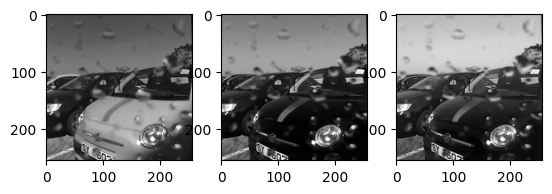

IoU:       0.0018541408935561776
Accuracy:  0.8767852783203125
Precision: 0.0019108280539512634
Recall:    0.058823529411764705


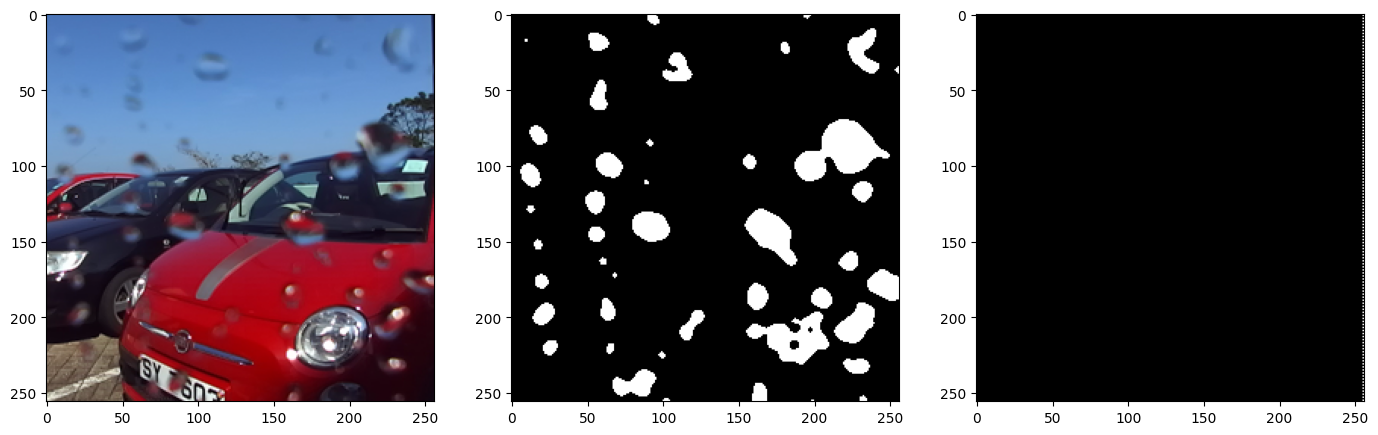

In [36]:
# Get prediction for random image and crop
from random import randint
idx = randint(0, len(val_dataset)-1)
print("Index:", idx)
x, y = val_dataset[idx]
show_channels(x)
plot_prediction(x, y, binary_map=True, binary_threshold=config["threshold"])

In [ ]:
# Get prediction from opened image
image_path = "../../data/derain/ALIGNED_PAIRS/CG_DROPLETS/left_1535201264389466.png"
mask_path = "../../data/derain/ALIGNED_PAIRS/CG_MASKS/left_1535201264389466.png"
from PIL import Image, ImageFilter
image = Image.open(image_path)
mask  = Image.open(mask_path)
x, y = dataset.transform(image, mask)
plot_prediction(x, y, binary_map=False)

In [ ]:
# Clear checkpoints by condition
#clear_checkpoints(config["checkpoint_dir"], condition=lambda ch: ch["train_loss"] >= 0.37, save_last=1)

In [12]:
!ls -la cg_checkpoints

total 11644056
drwxrwsr-x 2 kondrashov students      4096 Aug 16 20:03 .
drwxrwsr-x 8 kondrashov students      4096 Aug 17 17:09 ..
-rw-rw-r-- 1 kondrashov students       627 Aug 15 13:33 nullcheck
-rw-rw-r-- 1 kondrashov students 372617517 Aug  9 16:50 UNetAdamBCEt113v71e0.pt
-rw-rw-r-- 1 kondrashov students 372610293 Aug  9 14:51 UNetAdamBCEt55v57e0.pt
-rw-rw-r-- 1 kondrashov students 372617205 Aug  9 16:52 UNetAdamBCEt57v55e2.pt
-rw-rw-r-- 1 kondrashov students 372617205 Aug  9 16:51 UNetAdamBCEt60v56e1.pt
-rw-rw-r-- 1 kondrashov students 372610293 Aug  9 14:51 UNetAdamBCEt68v67e2.pt
-rw-rw-r-- 1 kondrashov students 372610293 Aug  9 14:51 UNetAdamBCEt68v68e1.pt
-rw-rw-r-- 1 kondrashov students 372610293 Aug  9 14:51 UNetAdamBCEt77v60e0.pt
-rw-rw-r-- 1 kondrashov students 372610293 Aug  9 14:51 UNetAdamBCEt82v68e0.pt
-rw-rw-r-- 1 kondrashov students 372610293 Aug  9 14:51 UNetAdamBCEt94v68e0.pt
-rw-rw-r-- 1 kondrashov students 372597045 Aug 15 18:05 UNetHSVBCEt14v14e33.pt
-rw-rw-r-- 

In [ ]:
!ls final_models

In [ ]:
!cp checkpoints/UNetRGBSBCEt31v31e56.pt final_models

In [ ]:
def modify_dataset():
    # Modify images to make them smoother
    save_dir = '../../data/derain/ALIGNED_PAIRS/CG_DROPLETS_M7'
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    step = 1
    for path in Path(config["image_dir"]).glob('*.png'):
        image = Image.open(path)
        image = image.filter(ImageFilter.MedianFilter(size = 5))
        new_path = Path(save_dir, path.name)
        image.save(new_path)
        print("Saved", new_path, step)
        step = step + 1

In [34]:
# Remove odd images
from pathlib import Path
def find_odd_files(dir1, dir2):
    for path in Path(dir1).glob('*.png'):
        name = path.name
        other_path = Path(dir2 + '/' + name)
        if not other_path.exists():
            print(other_path, "doesn't exist")
            print("Removed", path)
            path.unlink()

In [35]:
find_odd_files(
    dir1='../../data/stereo/train/image',
    dir2='../../data/stereo/train/mask'
)
find_odd_files(
    dir1='../../data/stereo/train/mask',
    dir2='../../data/stereo/train/image'
)

In [78]:
def test_all(checkpoint_dir, mode=""):
    from pathlib import Path
    files = list(Path(checkpoint_dir).glob('*.pt'))
    files = [f for f in files if f.name[4:len(mode)+5] == mode + "B"]
    #print(files)
    from torch import load
    for f in files:
        cp = load(f)
        print("Name:", cp["name"])
        model.load_state_dict(cp["model_state_dict"])
        test_loss, iou, acc, prec, rec = validate(model, loss_fn, test_loader)
        cp["iou"] = iou
        cp["accuracy"] = acc
        cp["precision"] = prec
        cp["recall"] = rec
        print("Test loss: ", test_loss)
        print_checkpoint(cp)
        print("\n")

In [79]:
test_all(config["checkpoint_dir"], mode=config["input_mode"])

Name: UNetRGBIBCEt30v31e103.pt
Test loss:  0.28292400389909744
Train BCE loss: 0.30879049712703344
Valid BCE loss: 0.3117707471052806
IoU:       0.5827348264865577 

Accuracy:  0.8620888921949598
Precision: 0.8075776560645965
Recall:    0.6767473956796167 



Name: UNetRGBIBCEt17v18e4.pt
Nan on validation
Nan on validation
Nan on validation
Nan on validation
Nan on validation
Nan on validation
Test loss:  -1
Train BCE loss: 0.17313787798663888
Valid BCE loss: 0.1811042312652834
IoU:       0.0 

Accuracy:  0.6269833776685927
Precision: 0.0
Recall:    0.0 



Name: UNetRGBIBCEt10v10e29.pt
Test loss:  3.825034221013387
Train BCE loss: 0.10298736832448556
Valid BCE loss: 0.10042375326156616
IoU:       0.31200428281186354 

Accuracy:  0.32870912551879883
Precision: 0.9856871167818705
Recall:    0.31488184285191206 



Name: UNetRGBIBCEt45v48e5.pt
Nan on validation
Nan on validation
Nan on validation
Nan on validation
Nan on validation
Nan on validation
Test loss:  -1
Train BCE loss: 0.45594